In [1]:
!pip install IPython
from IPython.display import Image

In [2]:
!pip install pandas_datareader
!pip install yfinance

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git # colab 사용시

In [ ]:
# Image('image/image_1.JPG') # 로컬 사용시
Image('/content/LG_time_series_day02_dataset/image/image_1.JPG') # colab 사용시

# [Recurrent Neural Networks - 회귀] 

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

### 1. 모듈 불러오기

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import time
import copy

import random

import matplotlib.pyplot as plt     

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

from sklearn.preprocessing import MinMaxScaler

import pandas_datareader.data as pdr
import yfinance as yfin

import warnings
warnings.filterwarnings(action='ignore') 

### 2. 데이터 불러오기

In [5]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data # 2380 rows × 9 

code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명': 'name', '종목코드': 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

yfin.pdr_override()

In [8]:
code_data

,name,code
0,DL,000210
1,DRB동일,004840
2,DSR,155660
3,GS,078930
4,KG케미칼,001390
...,...,...
2501,코스텍시스템,169670
2502,타임기술,318660
2503,플럼라인생명과학,222670
2504,한국미라클피플사,331660


In [9]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [10]:
stock_code = get_code(code_data, 'LG전자')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)
code_data['name']

[*********************100%***********************]  1 of 1 completed


0             DL
1          DRB동일
2            DSR
3             GS
4          KG케미칼
          ...   
2501      코스텍시스템
2502        타임기술
2503    플럼라인생명과학
2504    한국미라클피플사
2505         휴벡셀
Name: name, Length: 2506, dtype: object

In [11]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-04-24,58380.265625,59655.800781,53278.125000,55927.312500,45754.089844,4748665
2002-04-25,53964.953125,55338.605469,50825.171875,51413.882812,42061.667969,3988764
2002-04-26,50825.171875,54946.132812,49353.402344,53768.714844,43988.140625,4179962
2002-04-29,50334.582031,52395.062500,50334.582031,51217.644531,41901.117188,2028473
2002-04-30,51021.410156,51413.882812,49255.285156,50040.226562,40937.867188,2017364
...,...,...,...,...,...,...
2022-06-28,89100.000000,90100.000000,87800.000000,89000.000000,89000.000000,727402
2022-06-29,88000.000000,91800.000000,87400.000000,90700.000000,90700.000000,873866
2022-06-30,90900.000000,90900.000000,88300.000000,88300.000000,88300.000000,790624


#### 2.1 Data Exploratory Data Analysis

- High: 장 중 제일 높았던 주가(고가)
- Low: 장 중 제일 낮았던 주가(저가)
- Open: 장 시작 때 주가(시가)
- Close: 장 닫을 때 주가(종가)
- Volume: 주식 거래량
- Adj Close: 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

In [12]:
stock_data.head() # 상위 5개

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-04-24,58380.265625,59655.800781,53278.125000,55927.312500,45754.089844,4748665
2002-04-25,53964.953125,55338.605469,50825.171875,51413.882812,42061.667969,3988764
2002-04-26,50825.171875,54946.132812,49353.402344,53768.714844,43988.140625,4179962
2002-04-29,50334.582031,52395.062500,50334.582031,51217.644531,41901.117188,2028473
2002-04-30,51021.410156,51413.882812,49255.285156,50040.226562,40937.867188,2017364


In [13]:
stock_data.tail() # 하위 5개

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-28,89100.0,90100.0,87800.0,89000.0,89000.0,727402
2022-06-29,88000.0,91800.0,87400.0,90700.0,90700.0,873866
2022-06-30,90900.0,90900.0,88300.0,88300.0,88300.0,790624
2022-07-01,89000.0,92900.0,88800.0,89900.0,89900.0,1390290
2022-07-04,90800.0,91000.0,88600.0,90200.0,90200.0,693183


In [14]:
stock_data.shape # 데이터 차원 확인

(5039, 6)

In [15]:
stock_data.describe() # 데이터 통계값 확인

,Open,High,Low,Close,Adj Close,Volume
count,5039.000000,5039.000000,5039.000000,5039.000000,5039.000000,5.039000e+03
mean,78611.498134,79818.492320,77341.271690,78524.869172,73132.885947,1.115336e+06
std,27079.095316,27623.812600,26460.147956,27003.218388,27179.652184,8.521974e+05
min,29729.783203,30024.136719,27865.539062,29190.132812,23880.425781,0.000000e+00
25%,60636.984375,61500.000000,59950.156250,60600.000000,55113.498047,6.796415e+05
50%,71429.976562,72400.000000,70448.789062,71500.000000,66888.789062,9.488260e+05
75%,93100.000000,94389.609375,91076.796875,92819.718750,87697.687500,1.341686e+06
max,183000.000000,193000.000000,177500.000000,185000.000000,183860.500000,2.198205e+07


x_train shape is (4535, 5)
y_train shape is (4535, 1)
-----------------------------------
x_test shape is (504, 5)
y_test shape is (504, 1)
-----------------------------------
x_train examples


,Open,High,Low,Adj Close,Volume
Date,,,,,
2002-04-24,58380.265625,59655.800781,53278.125000,45754.089844,4748665
2002-04-25,53964.953125,55338.605469,50825.171875,42061.667969,3988764
2002-04-26,50825.171875,54946.132812,49353.402344,43988.140625,4179962
2002-04-29,50334.582031,52395.062500,50334.582031,41901.117188,2028473
2002-04-30,51021.410156,51413.882812,49255.285156,40937.867188,2017364


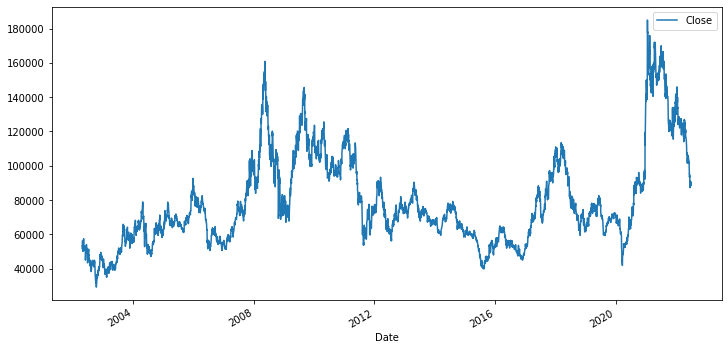

In [26]:
x = stock_data.drop(['Close'], axis=1)
y = stock_data[['Close']]

fig, ax = plt.subplots(figsize=(12, 6))
y.plot(ax = ax)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('x_train examples')
x_train.head()

In [27]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

columns_list = list(x_train.columns)
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print('x_train examples')
pd.DataFrame(x_train, columns = columns_list).head()

x_train examples


,Open,High,Low,Adj Close,Volume
0,0.215181,0.219796,0.202978,0.178596,0.334763
1,0.182019,0.187773,0.183386,0.148448,0.281193
2,0.158438,0.184862,0.171630,0.164177,0.294672
3,0.154753,0.165939,0.179467,0.147137,0.143000
4,0.159912,0.158661,0.170846,0.139272,0.142217


#### 2.2 Data Windowing

In [28]:
def windowing_process(x, y, window_size, shift_size, delay_day):
    try:
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
    except:
        pass
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size - delay_day + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        y_window.append(y[start_idx + window_size + delay_day - 1])
        
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [29]:
x_train, y_train = windowing_process(x_train, y_train, 5, 1, 1)
x_test, y_test = windowing_process(x_test, y_test, 5, 1, 1)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (4530, 5, 5)
y_train shape is (4530,)
-----------------------------------
x_test shape is (499, 5, 5)
y_test shape is (499,)


In [30]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (3624, 5, 5)
y_train shape is (3624,)
-----------------------------------
x_train shape is (906, 5, 5)
y_train shape is (906,)
-----------------------------------
x_test shape is (499, 5, 5)
y_test shape is (499,)


### 3. RNN Modeling

#### 3.1 Define the Model Structure

In [31]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, rnn_type, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # rnn_type에 따른 recurrent layer 설정
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, 1)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # 선택한 rnn_type의 RNN으로부터 output 도출
        if self.rnn_type in ['rnn', 'gru']:
            out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
            # initial cell states 설정
            c0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
            out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :])
        return out

#### 3.2 Define The Training Testing Strategy

In [32]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, device='cuda'): ##### config는 jupyter 파일을 참고
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.input_size = input_size

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 
        
        train_loss_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_loss = 999999999

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        outputs = outputs.reshape(-1)
                        
                        loss = criterion(outputs, targets)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_total += targets.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                                    
                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f}'.format(phase, epoch_loss))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)

        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val MSE: {:4f}'.format(best_loss))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():

            preds = []
            y_true = []
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                # input을 model에 넣어 output을 도출
                pred = model(inputs)
                
                preds.extend(pred.detach().cpu().numpy())
                y_true.extend(targets.detach().cpu().numpy())

            preds = torch.tensor(preds).reshape(-1)
            y_true = torch.tensor(y_true)
            
            mse = nn.MSELoss()(preds, y_true).item()
            preds = preds.detach().cpu().numpy()
        return preds, mse

### 4. Model Training

#### 4.1 Hyperparameter Setting

In [33]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='rnn'
best_model_path = f'./ckpt/{rnn_type}_stock_solutions_reg.pt'

#### 4.2 Construct Data Loaders and Model

In [34]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [35]:
model =  RNN_model(input_size, hidden_size, num_layers, bidirectional, rnn_type, device)
model = model.to(device)

#### 4.3 Model Training and Save Weights(Parameters)

In [36]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [37]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [38]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/200
train Loss: 0.0441
val Loss: 0.0088

Epoch 10/200
train Loss: 0.0004
val Loss: 0.0004

Epoch 20/200
train Loss: 0.0004
val Loss: 0.0003

Epoch 30/200
train Loss: 0.0004
val Loss: 0.0003

Epoch 40/200
train Loss: 0.0003
val Loss: 0.0003

Epoch 50/200
train Loss: 0.0003
val Loss: 0.0003

Epoch 60/200
train Loss: 0.0003
val Loss: 0.0003

Epoch 70/200
train Loss: 0.0003
val Loss: 0.0003

Epoch 80/200
train Loss: 0.0003
val Loss: 0.0003

Epoch 90/200
train Loss: 0.0003
val Loss: 0.0002

Epoch 100/200
train Loss: 0.0003
val Loss: 0.0002

Epoch 110/200
train Loss: 0.0003
val Loss: 0.0002

Epoch 120/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 130/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 140/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 150/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 160/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 170/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 180/200
train Loss: 0.0002
val Loss: 0.0002

Epoch 190/200
train Loss: 0.0002
val Loss

In [39]:
torch.save(best_model.state_dict(), best_model_path)

### 5. Model Validation

#### 5.1 Loss History Visualization

Text(0, 0.5, 'loss')

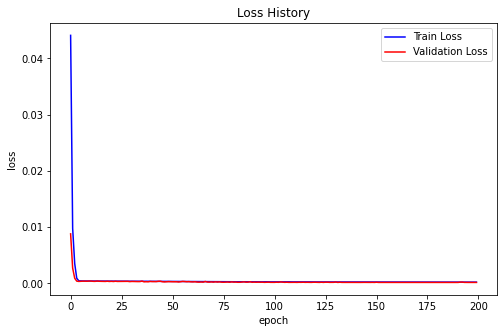

In [40]:
plt.figure(figsize=(8,5))
plt.title('Loss History')
plt.plot(range(num_epochs), train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

#### 5.2 Load Model Weights(Parameters)

In [41]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [42]:
y_pred, mse = trainer.test(model, test_loader)
y_pred_inverse = y_scaler.inverse_transform(pd.DataFrame(y_pred))
y_test_inverse = y_scaler.inverse_transform(pd.DataFrame(y_test))
y_train_inverse = y_scaler.inverse_transform(pd.DataFrame(y_train))
y_valid_inverse = y_scaler.inverse_transform(pd.DataFrame(y_valid))

print('y prediction (raw)')
print(y_pred)
print('-'*35)
print('y prediction (inverse minmax scaler)')
print(y_pred_inverse)

y prediction (raw)
[0.28236216 0.28863013 0.2699567  0.27113974 0.25938976 0.2616096
 0.27262723 0.27054584 0.27214772 0.2964418  0.28007555 0.2854706
 0.29847693 0.29510194 0.30117393 0.31701988 0.34636718 0.34211886
 0.35152566 0.35133177 0.3468169  0.35004938 0.33924502 0.34095323
 0.34048903 0.33050406 0.32754296 0.33089334 0.31879157 0.34115446
 0.3691551  0.3688298  0.36389434 0.3642527  0.42330974 0.40906417
 0.43420386 0.4384663  0.4477852  0.41628665 0.42748094 0.42951202
 0.46631068 0.46469575 0.4637177  0.4425835  0.43304682 0.4352709
 0.42469317 0.4442292  0.44050306 0.4301902  0.41248208 0.41489244
 0.43098426 0.46104848 0.48602962 0.47235256 0.47817302 0.4743827
 0.46943164 0.4634837  0.45940697 0.47077    0.4539075  0.46617442
 0.4599054  0.4832638  0.47880626 0.47704655 0.47938758 0.5072826
 0.5019504  0.4938109  0.4743489  0.48034346 0.4752255  0.47483963
 0.46359003 0.45626277 0.46289188 0.46459717 0.44787323 0.45747095
 0.45584238 0.45791113 0.45953822 0.43853146 0.4

In [43]:
def regression_report(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
      
    print('The regression reports are as follows:')
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(rmse,4))
    print('MAPE: ', round(mape,4))
    return r2, mae, mse, rmse, mape

r2, mae, mse, rmse, mape = regression_report (y_test_inverse.flatten(), y_pred_inverse.flatten())

The regression reports are as follows:
r2:  0.9842
MAE:  2364.7424
MSE:  13494898.458
RMSE:  3673.5403
MAPE:  1.8595


In [44]:
y_train_concat = np.concatenate([y_train_inverse, y_valid_inverse], axis=0)
y_train = np.concatenate([y_train_concat, np.array([np.nan]*len(y_test_inverse)).reshape(len(y_test_inverse), -1)], axis=0)
y_test = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_test_inverse], axis=0)
y_pred = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_pred_inverse], axis=0)

y_train = pd.DataFrame(y_train, columns = ['Train set'])
y_test = pd.DataFrame(y_test, columns = ['Test set'])
y_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

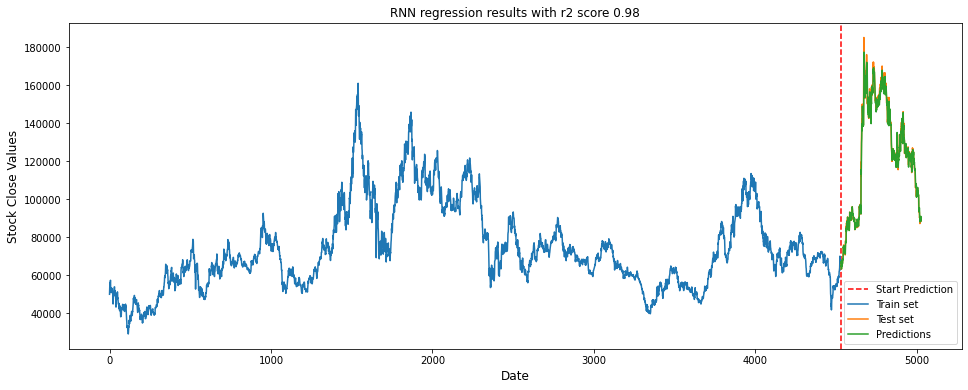

In [46]:
plt.figure(figsize=(16,6))
plt.title(f'RNN regression results with r2 score {np.round(r2, 2)}', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Close Values', fontsize=12)
plt.axvline(x=len(y_train_concat), color='r', label='Start Prediction', ls='--')
plt.plot(y_train['Train set'])
plt.plot(y_test['Test set'])
plt.plot(y_pred['Predictions'])
plt.legend(['Start Prediction', 'Train set', 'Test set', 'Predictions'], loc='lower right')
plt.show()

# EOD